<a href="https://colab.research.google.com/github/TharinsaMudalige/Neuron-Brain_Tumor_Detection_Classification_with_XAI/blob/Detection-Classification-VIT/Brain_Tumour_Detection_Using_VIT_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the Dataset

In [3]:
# Load dataset
def load_dataset(data_dir, target_size=(224, 224)):
    images = []
    labels = []
    for label, folder in enumerate(['tumor', 'no_tumor']):
        folder_path = os.path.join(data_dir, folder)
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_file)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size, color_mode='grayscale')
            img = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalize to [0, 1]
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

Define the Vision Transformer Model (ViT)

In [4]:
# Patches layer
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        batch_size = tf.shape(images)[0]
        num_patches = (images.shape[1] // self.patch_size) * (images.shape[2] // self.patch_size)
        patch_dims = patches.shape[-1]
        return tf.reshape(patches, [batch_size, num_patches, patch_dims])

# Self-attention mechanism
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(SelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.projection_dim = embed_dim // num_heads

        self.query_dense = tf.keras.layers.Dense(embed_dim)
        self.key_dense = tf.keras.layers.Dense(embed_dim)
        self.value_dense = tf.keras.layers.Dense(embed_dim)
        self.combine_heads = tf.keras.layers.Dense(embed_dim)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.split_heads(self.query_dense(inputs), batch_size)
        key = self.split_heads(self.key_dense(inputs), batch_size)
        value = self.split_heads(self.value_dense(inputs), batch_size)

        score = tf.matmul(query, key, transpose_b=True) / tf.math.sqrt(float(self.projection_dim))
        weights = tf.nn.softmax(score, axis=-1)
        attention = tf.matmul(weights, value)

        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        return self.combine_heads(concat_attention)

# Transformer block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dense(embed_dim)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.attention(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Patch encoder
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, embed_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(embed_dim)
        self.position_embedding = tf.keras.layers.Embedding(input_dim=num_patches, output_dim=embed_dim)

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        return self.projection(patches) + self.position_embedding(positions)

# Create the Vision Transformer model
def create_vit_model(input_shape, num_classes=2, patch_size=16, embed_dim=256, num_heads=8, ff_dim=512, num_layers=4):
    inputs = tf.keras.layers.Input(shape=input_shape)
    patches = Patches(patch_size)(inputs)
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    encoded_patches = PatchEncoder(num_patches, embed_dim)(patches)

    for _ in range(num_layers):
        encoded_patches = TransformerBlock(embed_dim, num_heads, ff_dim)(encoded_patches)

    x = tf.keras.layers.GlobalAveragePooling1D()(encoded_patches)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    return tf.keras.Model(inputs, outputs)

Load and Prepare the Dataset

In [5]:
data_dir = "/content/drive/MyDrive/DSGP_BrainTumorDetection/DSGP_Preprocessed_Images"
input_shape = (224, 224, 1)


Split the data into Training and Testing Sets

In [6]:
X, y = load_dataset(data_dir, target_size=(224, 224))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (4292, 224, 224, 1), Test shape: (1840, 224, 224, 1)


Create and Compile the ViT Model

Compile the Model

In [7]:
# Create the model
model = create_vit_model(input_shape=input_shape, num_classes=2)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

print("Model created successfully.")


Model created successfully.


Train the Model

In [8]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 485s 3s/step - accuracy: 0.5252 - loss: 0.7633 - val_accuracy: 0.6299 - val_loss: 0.6209
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 483s 3s/step - accuracy: 0.6754 - loss: 0.6074 - val_accuracy: 0.7701 - val_loss: 0.4921
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 509s 3s/step - accuracy: 0.8022 - loss: 0.4589 - val_accuracy: 0.7788 - val_loss: 0.5349
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 527s 4s/step - accuracy: 0.8501 - loss: 0.3683 - val_accuracy: 0.8837 - val_loss: 0.2959
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 501s 4s/step - accuracy: 0.9007 - loss: 0.2701 - val_accuracy: 0.8891 - val_loss: 0.2669
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 501s 4s/step - accuracy: 0.9199 - loss: 0.2184 - val_accuracy: 0.9185 - val_loss: 0.2335
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 448s 3s/step - accuracy: 0.9258 - loss: 0.2098 - val_accuracy: 0.9353 - val_loss: 0.1893
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 451s 3s/step - accuracy: 0.9387 - loss: 0.1639 - val_accu

Evaluate the Model

In [9]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=32)
y_pred = model.predict(X_test).argmax(axis=1)

# Precision and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")


58/58 ━━━━━━━━━━━━━━━━━━━━ 54s 927ms/step - accuracy: 0.9385 - loss: 0.2014
58/58 ━━━━━━━━━━━━━━━━━━━━ 56s 932ms/step
Test Accuracy: 94.24%
Test Precision: 91.66%
Test Recall: 96.98%


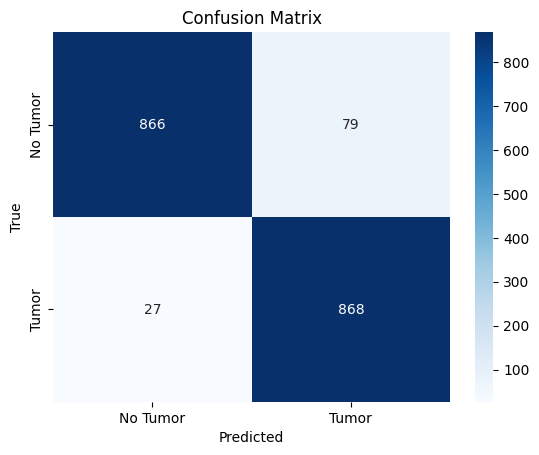

In [10]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Tumor", "Tumor"], yticklabels=["No Tumor", "Tumor"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()